In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_excel("data/jobGrowthByQuarter.xlsx")

In [3]:
data.shape

(23, 2)

In [4]:
data.head()

,Year & Quarter,Jobs Filled
0,2015-Q1,405
1,2015-Q2,100
2,2015-Q3,109
3,2015-Q4,138
4,2016-Q1,777


In [5]:
train, test = data.iloc[:16,:], data.iloc[16:,:]

In [6]:
model1 = pm.auto_arima(train['Jobs Filled'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=4)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=167.638, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=168.607, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=169.997, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=172.182, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=166.608, Time=0.05 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=168.218, Time=0.09 sec
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=168.209, Time=0.12 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=168.174, Time=0.05 sec
 ARIMA(0,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=168.607, Time=0.08 sec
 ARIMA(1,0,1)(1,1,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(1,1,0)[4]             : AIC=167.337, Time=0.02 sec

Best model:  ARIMA(0,0,0)(1,1,0)[4] intercept
Total fit time: 1.107 seconds


In [7]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                   16
Model:             SARIMAX(1, 1, 0, 4)   Log Likelihood                 -80.304
Date:                 Mon, 01 Feb 2021   AIC                            166.608
Time:                         10:50:19   BIC                            168.062
Sample:                              0   HQIC                           166.069
                                  - 16                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     72.1726    212.555      0.340      0.734    -344.428     488.773
ar.S.L4        0.6480      0.901      0.720      0.472      -1.117       2.413
sigma2      3.231e+04   1.46e+04      2.213      0.027    3694.415    6.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.93
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.04   Skew:                             2.08
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
nTest = len(test)

In [9]:
test_pred, confint = model1.predict(n_periods=nTest, return_conf_int=True)

C:\Users\skyst\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


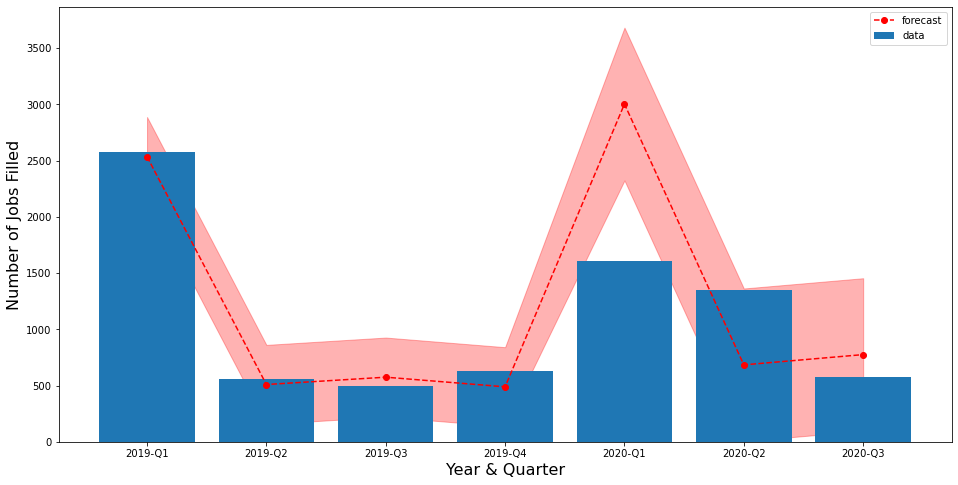

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(test.index, test['Jobs Filled'], label='data')
#ax.plot(test.index, test['Jobs Filled'], '--', marker='o', label='data')
ax.plot(test.index, test_pred, '--', marker='o', color='red', label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.set_xticklabels([0] + list(test["Year & Quarter"]))
plt.xlabel("Year & Quarter", fontsize=16)
plt.ylabel("Number of Jobs Filled", fontsize=16)
ax.legend();

In [11]:
test["Year & Quarter"]

16    2019-Q1
17    2019-Q2
18    2019-Q3
19    2019-Q4
20    2020-Q1
21    2020-Q2
22    2020-Q3
Name: Year & Quarter, dtype: object

C:\Users\skyst\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0, 0.5, 'Number of Jobs Filled')

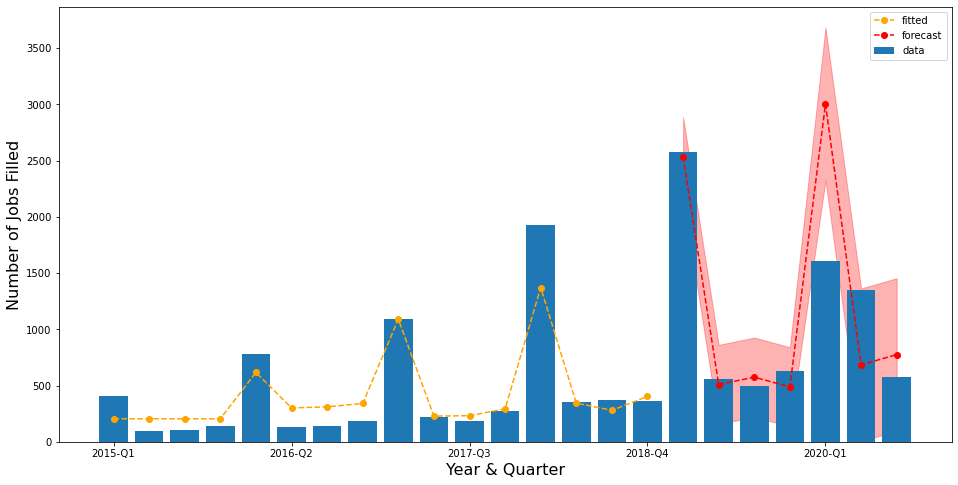

In [12]:
train_pred = model1.predict_in_sample(start=0, end=-1)

fig, ax = plt.subplots(figsize=(16, 8))
#ax.plot(data.index, data['Jobs Filled'], '--', marker='o', label='data')
ax.bar(data.index, data['Jobs Filled'], label='data')
ax.plot(train.index, train_pred, '--', marker='o', color='orange', label='fitted')
ax.plot(test.index, test_pred, '--', marker='o', color='red', label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
a = ax.get_xticks().tolist()
x = [ data["Year & Quarter"].iloc[int(a[i])] for i in range(0,len(a)-1) ]
ax.set_xticklabels(x)
ax.legend();
plt.xlabel("Year & Quarter", fontsize=16)
plt.ylabel("Number of Jobs Filled", fontsize=16)

In [13]:
### forecast RMSE
def rmse(t, y):
  return np.sqrt(np.mean((t - y)**2))

In [14]:
print("Train set RMSE:", rmse(train['Jobs Filled'], train_pred))
print("Validation set RMSE:", rmse(test['Jobs Filled'][:4], test_pred[:4]))
print("Test set RMSE:", rmse(test['Jobs Filled'][-3:], test_pred[-3:]))

Train set RMSE: 175.23775137561483
Validation set RMSE: 88.60330539213862
Test set RMSE: 899.5348441813333


In [15]:
pred = int(sum(test_pred[:4].round()))
actual = sum(test["Jobs Filled"][:4])
print("Predicted number of jobs created in 2019: ", pred )
print("Actual number of jobs created in 2019: ", actual )
print("Model is off by: ", round(100*(pred - actual) / actual,1), "% of the actual number of jobs created.")
print(" ")

pred = int(sum(test_pred[-3:].round()))
actual = sum(test["Jobs Filled"][-3:])
print("Predicted number of jobs created in 2020: ", pred )
print("Actual number of jobs created in 2020: ", actual )
print("Model is off by: ", round(100*(pred - actual) / actual,1), "% of the actual number of jobs created.")
print(" ")

Predicted number of jobs created in 2019:  4109
Actual number of jobs created in 2019:  4262
Model is off by:  -3.6 % of the actual number of jobs created.
 
Predicted number of jobs created in 2020:  4462
Actual number of jobs created in 2020:  3538
Model is off by:  26.1 % of the actual number of jobs created.
 


In [16]:
train, test = data.iloc[:20,:], data.iloc[20:,:]

In [17]:
model2 = pm.auto_arima(train['Jobs Filled'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=4)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=226.514, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=222.510, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=218.046, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=220.059, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=231.304, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=224.037, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=219.804, Time=0.14 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=219.858, Time=0.14 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=220.100, Time=0.05 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=216.062, Time=0.05 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=217.807, Time=0.10 sec
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=217.829, Time=0.11 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=218.481, Time=0.03 sec
 ARIMA(0,0,0)(2,1,1)[4] intercept   : AIC=inf, Time

In [18]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                   20
Model:             SARIMAX(1, 1, 0, 4)   Log Likelihood                -105.031
Date:                 Mon, 01 Feb 2021   AIC                            216.062
Time:                         10:50:21   BIC                            218.379
Sample:                              0   HQIC                           216.180
                                  - 20                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     69.5914    149.380      0.466      0.641    -223.187     362.370
ar.S.L4        0.6828      0.656      1.041      0.298      -0.603       1.969
sigma2      2.554e+04   8755.189      2.917      0.004    8378.934    4.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                27.24
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             2.12
Prob(H) (two-sided):                  0.47   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
nTest = len(test)
test_pred, confint = model2.predict(n_periods=nTest, return_conf_int=True)

C:\Users\skyst\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


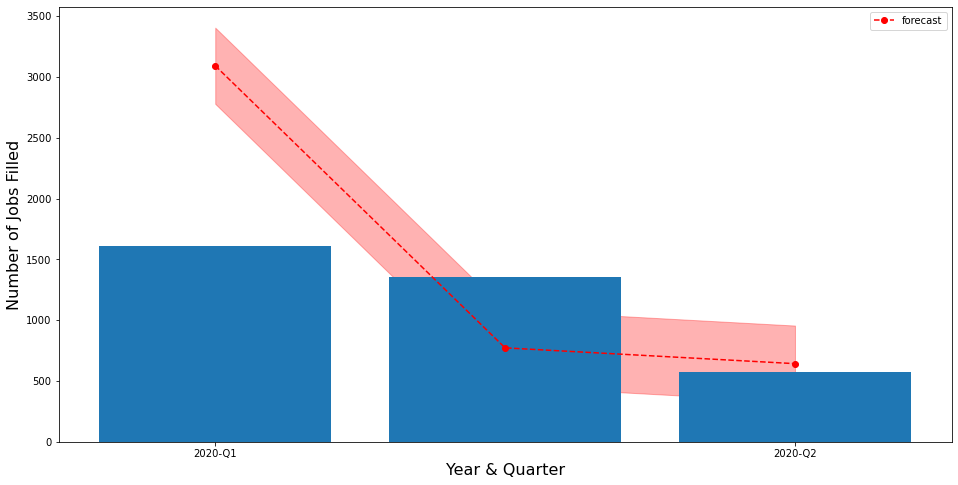

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))
#ax.plot(test.index, test['Jobs Filled'], '--', marker='o', label='data')
ax.bar(test.index, test['Jobs Filled'])
ax.plot(test.index, test_pred, '--', marker='o', color='red', label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
plt.locator_params(axis='x', nbins=3)
ax.set_xticklabels([0] + list(test["Year & Quarter"]))
plt.xlabel("Year & Quarter", fontsize=16)
plt.ylabel("Number of Jobs Filled", fontsize=16)
ax.legend();

C:\Users\skyst\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


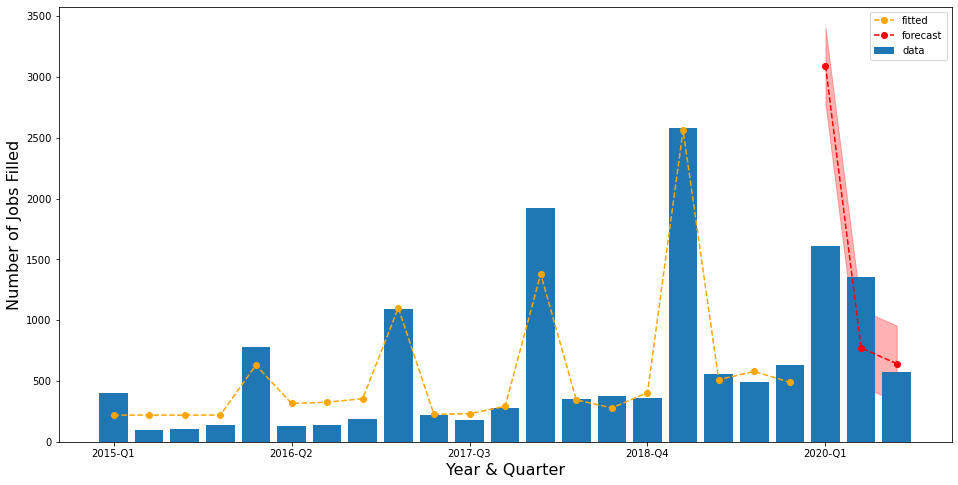

In [21]:
train_pred = model2.predict_in_sample(start=0, end=-1)

fig, ax = plt.subplots(figsize=(16, 8))
#ax.plot(data.index, data['Jobs Filled'],'--', marker='o', label='data')
ax.bar(data.index, data['Jobs Filled'], label='data')
ax.plot(train.index, train_pred,'--', marker='o', color='orange', label='fitted')
ax.plot(test.index, test_pred,'--', marker='o', color='red', label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
a = ax.get_xticks().tolist()
x = [ data["Year & Quarter"].iloc[int(a[i])] for i in range(0,len(a)-1) ]
ax.set_xticklabels(x)
plt.xlabel("Year & Quarter", fontsize=16)
plt.ylabel("Number of Jobs Filled", fontsize=16)
ax.legend();

In [22]:
print("Train set RMSE:", rmse(train['Jobs Filled'], train_pred))
print("Old Validation set RMSE:", rmse(train['Jobs Filled'][-4:], train_pred[-4:]))
print("Test set RMSE:", rmse(test['Jobs Filled'][-3:], test_pred[-3:]))

Train set RMSE: 162.11967212118006
Old Validation set RMSE: 87.03063328580666
Test set RMSE: 919.4455849436653


In [23]:
pred = int(sum(test_pred.round()))
actual = sum(test["Jobs Filled"])
print("Predicted number of jobs created in 2020: ", pred )
print("Actual number of jobs created in 2020: ", actual )
print("Model is off by", round(100*(pred - actual) / actual,1), "% of the actual number of jobs created.")

Predicted number of jobs created in 2020:  4506
Actual number of jobs created in 2020:  3538
Model is off by 27.4 % of the actual number of jobs created.
